# Step1: Prepare Road Network

In [1]:
import osmnx as ox
road_file = 'porto.graphml'
road_folder = 'D:/MapMatchingPython/data/osm/porto_road'

road_graph = ox.load_graphml(filename=road_file, folder=road_folder)
road_graph_utm = ox.project_graph(road_graph)

In [2]:
road_graph.graph['crs']

{'init': 'epsg:4326'}

In [3]:
road_graph_utm.graph['crs']

{'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'utm', 'units': 'm', 'zone': 29}

### Extract Edge Data from Road Network

In [4]:
def road_graph_to_edge_gpd(road_graph):
    '''
    store road segments into a geppandas dataframe
    :param road_graph: a road network graph in networkx
    :return gpd_edges: a geopandas dataframe of road segments
    '''
    from shapely.geometry import Point, LineString
    import geopandas as gpd
    #froms = []
    #tos = []
    #geometries = []
    gpd_edges = gpd.GeoDataFrame(columns=('from','to','geometry','length','highway'))
    for e_from, e_to, data in road_graph.edges(data=True):
        #froms.append(e_from)
        #tos.append(e_to)
        if 'geometry' in data:
            #geometries.append(data['geometry'])
            s = gpd.GeoSeries({'from':e_from, 
                               'to':e_to, 
                               'geometry':data['geometry'], 
                               'length':data['length'],
                               'highway':data['highway']})
            gpd_edges = gpd_edges.append(s, ignore_index=True)
        else:
            p1 = Point(road_graph.nodes[e_from]['x'], road_graph.nodes[e_from]['y'])
            p2 = Point(road_graph.nodes[e_to]['x'], road_graph.nodes[e_to]['y'])
            #geometries.append(LineString((p1, p2)))
            data.update({'geometry':LineString((p1, p2))})
            s = gpd.GeoSeries({'from':e_from, 
                               'to':e_to, 
                               'geometry':LineString((p1, p2)), 
                               'length':data['length'],
                               'highway':data['highway']})
            gpd_edges = gpd_edges.append(s, ignore_index=True)

    #gpd_edges = gpd.GeoDataFrame(data={'from': froms, 'to': tos, 'geometry': geometries})
    gpd_edges.crs = road_graph.graph['crs']
    gpd_edges.name = 'edges'
    # create bounding box for each edge geometry
    gpd_edges['bbox'] = gpd_edges.apply(lambda row: row['geometry'].bounds, axis=1)
    return gpd_edges

In [5]:
gpd_edges_utm = road_graph_to_edge_gpd(road_graph_utm)
gpd_edges_utm.head()

,from,to,geometry,length,highway,bbox
0,296058885,1628753289,LINESTRING (531068.006566746 4558739.619749674...,155.377405,secondary,"(531068.006567, 4558592.64786, 531117.808982, ..."
1,296058885,1561621045,LINESTRING (531068.006566746 4558739.619749674...,67.837805,primary,"(531068.006567, 4558739.61975, 531135.491049, ..."
2,2185756687,435240914,LINESTRING (533863.3661556013 4558657.15794647...,260.154858,"[residential, service]","(533676.804891, 4558563.44126, 533863.366156, ..."
3,2185756687,506111741,LINESTRING (533863.3661556013 4558657.15794647...,175.753043,service,"(533863.366156, 4558641.90652, 534038.822479, ..."
4,299597866,299598639,LINESTRING (534689.3168561951 4558013.88137999...,54.764152,residential,"(534689.316856, 4558013.88138, 534723.50894, 4..."


In [6]:
for item in gpd_edges_utm['highway']:
    if isinstance(item, list):
        print item

[u'residential', u'service']
[u'residential', u'living_street']
[u'residential', u'living_street']
[u'residential', u'living_street']
[u'residential', u'service']
[u'residential', u'service']
[u'residential', u'living_street']
[u'residential', u'living_street']
[u'residential', u'service']
[u'residential', u'service']
[u'residential', u'living_street']
[u'secondary', u'secondary_link']
[u'secondary', u'secondary_link']
[u'residential', u'service']
[u'unclassified', u'living_street']
[u'residential', u'living_street']
[u'residential', u'service']
[u'residential', u'living_street']
[u'residential', u'service']
[u'residential', u'service']
[u'residential', u'living_street']
[u'residential', u'living_street']
[u'residential', u'living_street']
[u'residential', u'service']
[u'residential', u'service']
[u'residential', u'living_street']
[u'unclassified', u'residential']
[u'living_street', u'service']
[u'residential', u'living_street']
[u'residential', u'service']
[u'unclassified', u'living_s

### Add max speed information

In [7]:
def get_max_speed(highway):
    '''
    return the corresponding max speed in kmph 
    '''
    if highway == 'mortorway':
        return 100
    elif highway == 'mortorway_link':
        return 60
    elif highway == 'trunk':
        return 80
    elif highway == 'trunk_link':
        return 40
    elif highway == 'primary':
        return 60
    elif highway == 'primary_link':
        return 40
    elif highway == 'secondary':
        return 50
    elif highway == 'secondary_link':
        return 20
    elif highway == 'residential':
        return 30
    elif highway == 'teritiary':
        return 50
    elif highway == 'teritiary_link':
        return 20
    elif highway == 'living_street':
        return 20
    elif highway == 'road':
        return 20
    elif highway == 'service':
        return 20
    else:
        return 50
        
    
def get_max_speeds(gpd_edges_utm):
    max_speeds = []
    for idx, row in gpd_edges_utm.iterrows():
        if isinstance(row['highway'], list):
            max_speed1 = get_max_speed(row['highway'][0])
            max_speed2 = get_max_speed(row['highway'][1])
            if row['length'] > 100:
                max_speed = max(max_speed1, max_speed2)
                max_speeds.append(max_speed)
            else:
                max_speed = min(max_speed1, max_speed2)
                max_speeds.append(max_speed)
        else:
            max_speeds.append(get_max_speed(row['highway']))
    return max_speeds

In [8]:
max_speeds = get_max_speeds(gpd_edges_utm)
gpd_edges_utm['max speed'] = max_speeds
gpd_edges_utm.head()

,from,to,geometry,length,highway,bbox,max speed
0,296058885,1628753289,LINESTRING (531068.006566746 4558739.619749674...,155.377405,secondary,"(531068.006567, 4558592.64786, 531117.808982, ...",50
1,296058885,1561621045,LINESTRING (531068.006566746 4558739.619749674...,67.837805,primary,"(531068.006567, 4558739.61975, 531135.491049, ...",60
2,2185756687,435240914,LINESTRING (533863.3661556013 4558657.15794647...,260.154858,"[residential, service]","(533676.804891, 4558563.44126, 533863.366156, ...",30
3,2185756687,506111741,LINESTRING (533863.3661556013 4558657.15794647...,175.753043,service,"(533863.366156, 4558641.90652, 534038.822479, ...",20
4,299597866,299598639,LINESTRING (534689.3168561951 4558013.88137999...,54.764152,residential,"(534689.316856, 4558013.88138, 534723.50894, 4...",30


In [9]:
gpd_edges_utm['max speed'].value_counts()

30    6352
20    3698
50    2826
60     612
40      83
80      11
Name: max speed, dtype: int64

# Step2: Build R-tree Index for Road Network

In [10]:
def build_rtree_index_edges(gpd_edges):
    '''
    build a r-tree index for road segments
    input:
        gpd_edges: a geopandas dataframe that contains road segments (edge geometries)
    output:
        idx: a r-tree index of the edge geometries
    '''
    # r-tree index for edges
    from rtree import index
    p = index.Property()
    idx = index.Index(properties=p)
    for index, row in gpd_edges.iterrows():
        idx.insert(index, row['bbox'], obj=row)
    return idx

In [11]:
edge_idx = build_rtree_index_edges(gpd_edges_utm)

# Step3: Load Trajectory

In [12]:
def read_trip(filename):
    '''
    read trajectory from csv file
    '''
    import pandas as pd
    import geopandas as gpd
    from shapely.geometry import Point
    col_names = ['obj_id', 'lat', 'lon', 'timestamp', 'unknown1', 'unknow2']
    trip = pd.read_csv(filename, header=None, names=col_names)
    trip.drop(['unknown1', 'unknow2'], axis=1, inplace=True)
    trip['geometry'] = trip.apply(lambda z: Point(z.lon, z.lat), axis=1)
    trip = gpd.GeoDataFrame(trip)
    return trip

In [13]:
trip_folder = 'D:/MapMatchingPython/data/trips'
trip_file = trip_folder + '/trip_0.txt'
trip = read_trip(trip_file)
trip.head()

,obj_id,lat,lon,timestamp,geometry
0,20000589,41.141412,-8.618643,1372636858,POINT (-8.618642999999999 41.141412)
1,20000589,41.141376,-8.618499,1372636873,POINT (-8.618499 41.141376)
2,20000589,41.142510,-8.620326,1372636888,POINT (-8.620325999999999 41.14250999999999)
3,20000589,41.143815,-8.622153,1372636903,POINT (-8.622152999999999 41.143815)
4,20000589,41.144373,-8.623953,1372636918,POINT (-8.623953 41.144373)


### coordinate transformation

In [14]:
### coordinate transformation
def transform_coordinates(point, crs, to_crs):
    import osmnx as ox
    return ox.project_geometry(point,crs, to_crs)[0]

In [15]:
crs = road_graph.graph['crs']
to_crs = road_graph_utm.graph['crs']
trip['geometry_utm'] = trip.apply(lambda row: transform_coordinates(row['geometry'], crs, to_crs), axis=1)
trip.head()

,obj_id,lat,lon,timestamp,geometry,geometry_utm
0,20000589,41.141412,-8.618643,1372636858,POINT (-8.618642999999999 41.141412),POINT (532004.0931626002 4554525.40328601)
1,20000589,41.141376,-8.618499,1372636873,POINT (-8.618499 41.141376),POINT (532016.1954063133 4554521.459764727)
2,20000589,41.142510,-8.620326,1372636888,POINT (-8.620325999999999 41.14250999999999),POINT (531862.321380579 4554646.677934005)
3,20000589,41.143815,-8.622153,1372636903,POINT (-8.622152999999999 41.143815),POINT (531708.3702606896 4554790.882491105)
4,20000589,41.144373,-8.623953,1372636918,POINT (-8.623953 41.144373),POINT (531557.0490813914 4554852.173654097)


# Step4: Query candidates

In [16]:
def query_k_nearest_road_segments(edge_idx, point, k):
    from shapely.geometry import Point, LineString
    from shapely.ops import nearest_points
    import pandas as pd
    '''
    query k-nearest road segments of a given point
    :param edge_idx: the road segments r-tree index
    :param point: the given point
    :param k: the number of segments needed to query
    :return: k candidates as a pandas DataFrame
    '''
    candidates = pd.DataFrame(columns=('distance', 'from', 'to', 'proj_point', 'road'))
    hits = edge_idx.nearest((point.x, point.y, point.x, point.y), k, objects=True)
    for item in hits:
        results = nearest_points(point, item.object['geometry'])
        d = point.distance(results[1])
        s = pd.Series({'distance':d,
                       'from':item.object['from'], 
                       'to':item.object['to'], 
                       'proj_point':results[1],
                      'road':item.object})
        candidates = candidates.append(s, ignore_index=True)
    #candidates['observation prob'] = candidates.apply(lambda row: normal_distribution())
    candidates.sort_values(by='distance', axis=0, inplace=True)
    return candidates


def find_candidates(trip, road_idx, k):
    '''
    given a trip, find candidates points for each point in the trip
    :param trip: a GPS trajectory (without coordinates transform)
    :param road_idx: road segments r-tree index of the corresponding road network
    :param k: the number of candidates
    :return: the trip with candidates
    '''
    candi_list = []
    #point_list = []
    #crs = road_graph.graph['crs']
    #to_crs = road_graph_utm.graph['crs']
    for i in range(0, len(trip)):
        #candidates = []
        #point_utm = ox.project_geometry(trip.iloc[i]['geometry'], crs=crs, to_crs=to_crs)[0]
        #point_list.append(point_utm)
        candidates = query_k_nearest_road_segments(edge_idx, trip.iloc[i]['geometry_utm'], k)
        candi_list.append(candidates)
    trip['candidates'] = candi_list
    #trip['geometry_utm'] = point_list
    #return trip

In [17]:
k = 3
find_candidates(trip, edge_idx, k)
trip.head()

,obj_id,lat,lon,timestamp,geometry,geometry_utm,candidates
0,20000589,41.141412,-8.618643,1372636858,POINT (-8.618642999999999 41.141412),POINT (532004.0931626002 4554525.40328601),distance from to \ 0 4....
1,20000589,41.141376,-8.618499,1372636873,POINT (-8.618499 41.141376),POINT (532016.1954063133 4554521.459764727),distance from to \ 0 2....
2,20000589,41.142510,-8.620326,1372636888,POINT (-8.620325999999999 41.14250999999999),POINT (531862.321380579 4554646.677934005),distance from to \ 0 3....
3,20000589,41.143815,-8.622153,1372636903,POINT (-8.622152999999999 41.143815),POINT (531708.3702606896 4554790.882491105),distance from to \ 0 0....
4,20000589,41.144373,-8.623953,1372636918,POINT (-8.623953 41.144373),POINT (531557.0490813914 4554852.173654097),distance from to \ 0 0.86...


#### Visualize candidates of a specified GPS point

In [18]:
def visualize_candidates_of_a_point(trip, gps_idx, candi_idx):
    import matplotlib.pyplot as plt
    from shapely.geometry import LineString
    fig, ax= plt.subplots(figsize=(10,8))
    # the raw point
    point = trip.iloc[gps_idx]['geometry_utm']
    ax.plot(point.x, point.y, '*', color='blue', label='raw point', zorder=1)
    # the nearest road segment
    edge_start = trip.iloc[gps_idx]['candidates'].iloc[candi_idx]['from']
    edge_to = trip.iloc[gps_idx]['candidates'].iloc[candi_idx]['to']
    #line = road_graph_utm[edge_start][edge_to][0]['geometry']
    line = trip.iloc[gps_idx]['candidates'].iloc[candi_idx]['road']['geometry']
    x,y = line.xy
    ax.plot(x,y, zorder=2)
    # the projected point on the road segment
    proj_point = trip.iloc[gps_idx]['candidates'].iloc[candi_idx]['proj_point']
    ax.plot(proj_point.x, proj_point.y, '+', color='red', label='projected point', zorder=3)    
    # nearest points
    from shapely.ops import nearest_points
    results = nearest_points(point, line)
    #ax.plot(results[0].x, results[0].y, 'o', color='black', zorder=4)
    ax.plot(results[1].x, results[1].y, 'o', color='black', label='projected point new', zorder=5, alpha = 0.2)
    ax.get_legend_handles_labels()
    ax.legend()
    ax.axis('off')

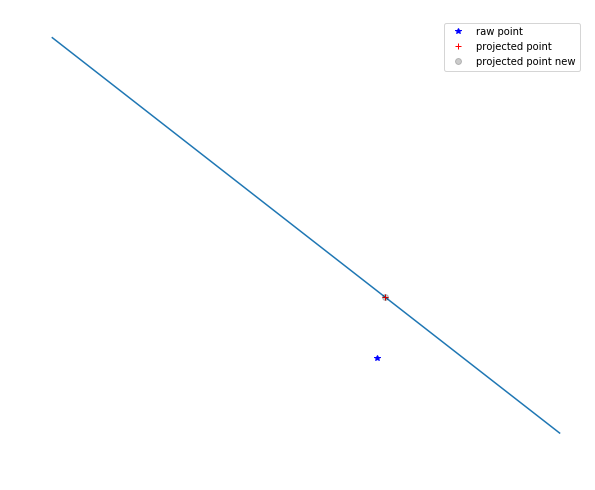

In [19]:
i = 19
j = 0
visualize_candidates_of_a_point(trip, i, j)

## Visualize trip and candidates

### visualize trip and candidates by smopy

In [20]:
def trip_bbox(trip):
    '''
    get the bounding box of the given trip
    input: trip: a trajectory
    output: (minx, miny, maxx, maxy)
    '''
    from shapely.geometry import LineString
    line = LineString(list(trip['geometry']))
    return line.bounds

def get_candidates_coordinates_as_series(trip, crs, to_crs):
    if 'candidates' not in trip:
        return [],[]
    import pandas as pd
    Xs = []
    Ys = []
    for i in range(0, len(trip)):
        for j in range(0, len(trip.iloc[i]['candidates'])):
            p = transform_coordinates(trip.iloc[i]['candidates'].iloc[j]['proj_point'], crs, to_crs)
            Xs.append(p.x)
            Ys.append(p.y)
    Xs = pd.Series(Xs)
    Ys = pd.Series(Ys)
    return Xs, Ys


def visualize_by_smopy(trip, crs, to_crs):
    import smopy
    (minx, miny, maxx, maxy) = trip_bbox(trip)
    map = smopy.Map((miny, minx, maxy, maxx), z=15)
    #map = smopy.Map(trip_bbox(trip), z=15)    
    ax = map.show_mpl(figsize=(10, 12))
    # Plot the itinerary.
    x,y = map.to_pixels(trip['lat'], trip['lon'])
    ax.plot(x, y, '-k', lw=3)
    # Mark our two positions.
    #ax.plot(list(x)[0], list(y)[0], 'bo', ms=10)
    #ax.plot(list(x)[-1], list(y)[-1], 'ro', ms=10)
    Xs,Ys = get_candidates_coordinates_as_series(trip, crs, to_crs)
    xs, ys = map.to_pixels(Ys, Xs)
    ax.plot(xs, ys, 'r+', ms=10)


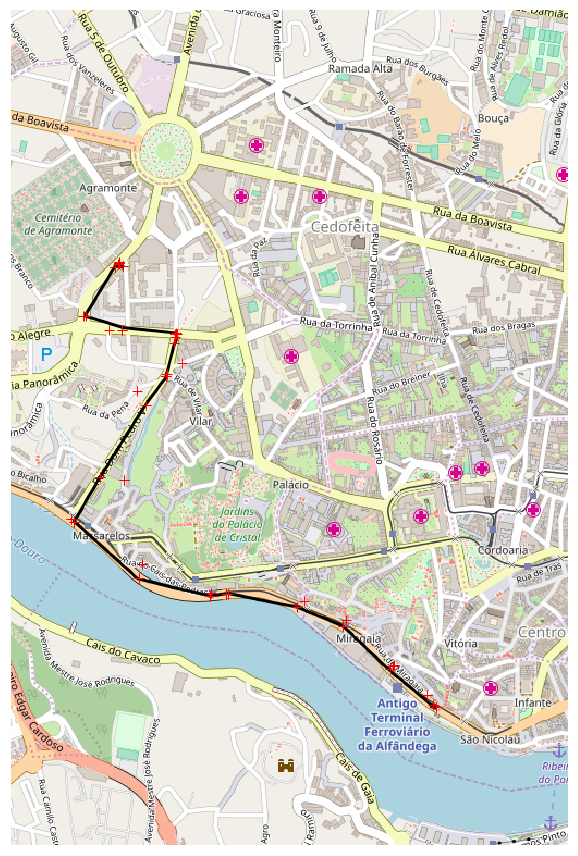

In [21]:
crs_utm = road_graph_utm.graph['crs']
crs_wgs84 = road_graph.graph['crs']
visualize_by_smopy(trip, crs_utm, crs_wgs84)

### visualize trip and candidates by folium

In [22]:
def get_candidates_as_points_list(trip, crs, to_crs):
    if 'candidates' not in trip:
        return []
    candi_points = []
    for i in range(0, len(trip)):
        for j in range(0, len(trip.iloc[i]['candidates'])):
            p = transform_coordinates(trip.iloc[i]['candidates'].iloc[j]['proj_point'], crs, to_crs)   # projected point
            candi_points.append(tuple([p.y, p.x]))
    return candi_points


def visualize_by_folium(trip, crs, to_crs):
    import folium
    # load map
    (minx, miny, maxx, maxy) = trip_bbox(trip)
    lon = (maxx+minx)/2.0
    lat = (maxy+miny)/2.0
    map_porto = folium.Map(location=[lat,lon], zoom_start=15)
    # trip to points
    points = []
    for row in trip.to_records(index=False):
        points.append(tuple([row['lat'], row['lon']]))
    # add lines
    #print points
    folium.PolyLine(points, color='red', weight=2.5, opacity=1).add_to(map_porto)
    # add points
    for i in range(len(points)):
        if i==0:
            folium.Marker(points[i], popup='start',icon=folium.Icon(color='green')).add_to(map_porto)
        elif i==len(points)-1:
            folium.Marker(points[i], popup='end',icon=folium.Icon(color='red')).add_to(map_porto)
        else:
            #folium.RegularPolygonMarker(points[i], popup=str(i), fill_color='#45647d',number_of_sides=8, radius=10).add_to(map_porto)
            folium.Marker(points[i], icon=folium.Icon(color='black')).add_to(map_porto)
    # candidates visualization
    candi_points = get_candidates_as_points_list(trip, crs, to_crs)
    folium.PolyLine(candi_points, color='red', weight=2.5, opacity=1).add_to(map_porto)
    #print candi_points
    for i in range(len(candi_points)):
        #print candi_points[i]
        #folium.RegularPolygonMarker(candi_points[i], fill_color='blue',number_of_sides=8, radius=10).add_to(map_porto)
        folium.Marker(candi_points[i], icon=folium.Icon(color='blue')).add_to(map_porto)
    
    return map_porto

In [23]:
crs_utm = road_graph_utm.graph['crs']
crs_wgs84 = road_graph.graph['crs']
        
visualize_by_folium(trip, crs_utm, crs_wgs84)

### Visualize trip and candidates by matplotlib

In [24]:
def trip_bbox_utm(trip):
    '''
    get the bounding box of the given trip
    input: trip: a trajectory
    output: (minx, miny, maxx, maxy)
    '''
    from shapely.geometry import LineString
    line = LineString(list(trip['geometry_utm']))    
    return line.buffer(500).bounds

def get_candidates_as_geodataframe(trip):
    import geopandas as gpd
    if 'candidates' not in trip:
        return []
    candi_points = []
    for i in range(0, len(trip)):
        for j in range(0, len(trip.iloc[i]['candidates'])):
            candi_points.append(trip.iloc[i]['candidates'].iloc[j]['proj_point'])
    return gpd.GeoDataFrame(data={'geometry':candi_points})


def visualize_trip_candidates(trip, edge_idx, figname='temp.pdf'):
    '''visualize trip points and their corresponding candidates'''
    import geopandas as gpd
    # prepare data
    edges_collection = gpd.GeoDataFrame(list(edge_idx.intersection(trip_bbox_utm(trip), objects='raw')))
    candidates = get_candidates_as_geodataframe(trip)
    trip_utm = gpd.GeoDataFrame(data={'geometry':trip['geometry_utm']})
    # plotting
    ax = edges_collection.plot(figsize=(16,14), color='black', alpha=0.1)
    trip_utm.plot(ax=ax, color='red', marker='o', markersize=10, label='raw points')
    candidates.plot(ax=ax, color='green', marker='+', markersize=50, label='candidates', alpha=0.5)
    ax.get_legend_handles_labels()
    ax.legend()
    ax.axis('off')
    ax.figure.savefig(figname,dpi=800, format='pdf')

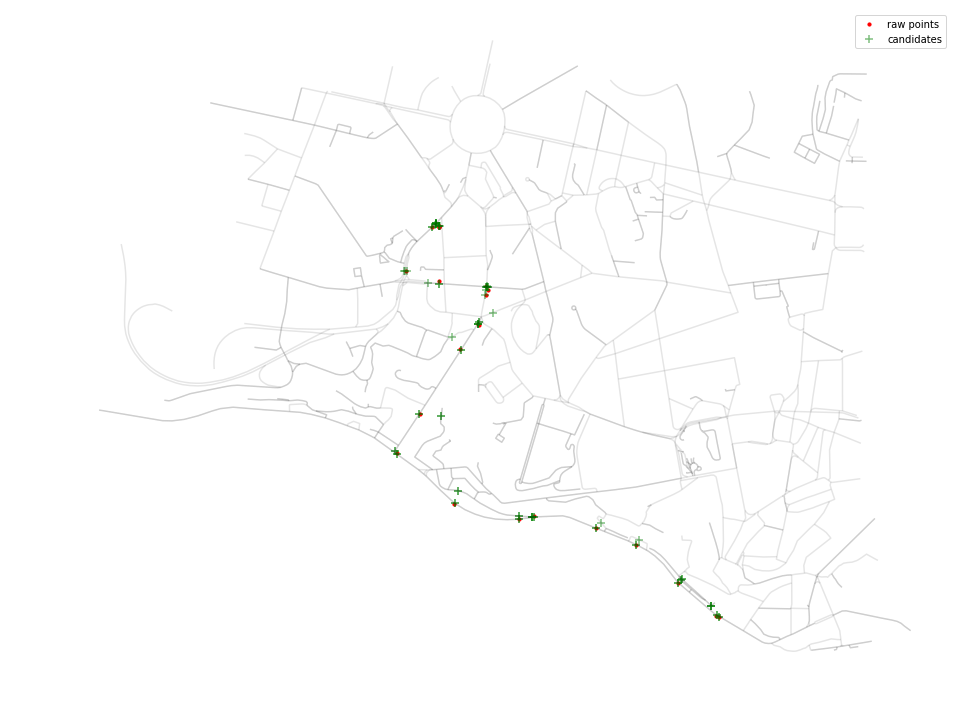

In [25]:
visualize_trip_candidates(trip, edge_idx, 'trip_0.pdf')

# Step5: Calculate Weights

#### Step5.1 calculate observation probability

In [26]:
def normal_distribution(mu, sigma, x):
    '''
    calculate normal distribution values
    input:
    mu: the mean value
    sigma; the standard deviation
    x: the given variables
    output:
    the probabilities of given input variables x
    '''
    import numpy as np
    return 1.0/(sigma * np.sqrt(2*np.pi)) * ( np.exp(-1.0 * (np.array(x)-mu)**2 / (2 * sigma**2)) )

#x = [10,20,30,40,50]
#mu = 0
#sigma = 20
#normal_distribution(mu,sigma,x)
def calculate_observation_probability(trip, mu, sigma):
    for i in range(len(trip)):
        trip.iloc[i]['candidates']['observation prob']=trip.iloc[i]['candidates'].apply(
            lambda row: normal_distribution(mu,sigma,row['distance']), 
            axis=1)

In [27]:
mu = 0
sigma = 10
calculate_observation_probability(trip, mu, sigma)
trip.iloc[19]['candidates']

,distance,from,to,proj_point,road,observation prob
0,1.347345,129800102,129800097,POINT (530975.6675954409 4555975.991135573),from ...,0.039534
1,16.779269,129800102,129795309,POINT (530962.9907366547 4555986.154101696),from ...,0.009762
2,16.779269,129795309,129800102,POINT (530962.9907366547 4555986.154101696),from ...,0.009762


#### Step5.2 Calculate transmission probability and ST Function Values

In [28]:
def get_edge_info(gpd_edges_utm, from_id, to_id):
    results = gpd_edges_utm[(gpd_edges_utm['from']==from_id) & (gpd_edges_utm['to']==to_id)]
    if len(results) > 1:
        if results.iloc[0]['length']<results.iloc[1]['length']:
            return results.iloc[0]
        else:
            return results.iloc[1]
    else:
        return results.iloc[0]

def network_distance(raod_graph_utm, gpd_edges_utm, candidate1, candidate2):
    import networkx as nx
    '''
    calculate network distance between two candidates
    input:
    G: the road network
    candidate1: a candidate (from, to, proj_point, distance) represents as a pandas series 
    candidate2: a candidate (from, to, proj_point, distance) represents as a pandas series
    output:
    the shortest path distance between the given two candidates
    '''
    d = 0
    sp_edges = []
    p1 = candidate1['proj_point']
    #edge1 = road_graph_utm[candidate1['from']][candidate1['to']][0]
    edge1 = candidate1['road']
    p2 = candidate2['proj_point']
    #edge2 = road_graph_utm[candidate2['from']][candidate2['to']][0]
    edge2 = candidate2['road']
    #if (candidate1['from'] == candidate2['from'] & candidate1['to'] == candidate2['to']):
    if edge1['geometry'] == edge2['geometry']:
        # part 2 of the distance from the projected point of candidate1 to the end point of the corresponding edge
        d2 = edge1['geometry'].project(p1)
        # part 3 of the distance from the start point of the corresponding edge to the projected candidate2
        d3 = edge2['geometry'].project(p2)
        d = d3-d2
        sp_edges.append(edge1)
        #print('case1')
        #print d2, d3
        #if d<0: print 'case1'
    elif candidate1['to'] == candidate2['from']:
        # part 2 of the distance from the projected point of candidate1 to the end point of the corresponding edge
        d2 = edge1['length'] - edge1['geometry'].project(p1)
        # part 3 of the distance from the start point of the corresponding edge to the projected candidate2
        d3 = edge2['geometry'].project(p2)   
        d = d2+d3
        sp_edges.append(edge1)
        sp_edges.append(edge2)
        #print('case2')
        #print d2, d3
        #if d<0: 
        #    print 'case2'
        #    print d2
        #    print d3
    else:
        # part 1 of the distance 
        source = candidate1['to']
        target = candidate2['from']
        try:
            d1 = nx.shortest_path_length(road_graph_utm, source, target, weight='length')
            sp = nx.shortest_path(road_graph_utm, source, target, weight='length')
        except Exception as err:
            print err
            d = 100000000
        else:            
            # part 2 of the distance from the projected point of candidate1 to the end point of the corresponding edge
            d2 = edge1['length'] - edge1['geometry'].project(p1)
            # part 3 of the distance from the start point of the corresponding edge to the projected candidate2
            d3 = edge2['geometry'].project(p2)
            d = d1+d2+d3
            if d1 > 0 :
                sp_edges.append(edge1)
            for i in range(len(sp)-1):
                sp_edges.append(get_edge_info(gpd_edges_utm,sp[i],sp[i+1]))
            if d2 > 0 :
                sp_edges.append(edge2)
            #print('case1')
            #print d1, d2, d3
            #if d<0:print 'case3'            
        #if d < 0:
        #    print(candidate1, candidate2)
    return d,sp_edges

#def great_circle_distance(raod_graph_utm, candidate1, candidate2):
#    '''
#    calculate euclidean distance between two candidates
#    '''
#    return candidate1['proj_point'].distance(candidate2['proj_point'])
#network_distance(road_graph_utm, trip.iloc[0]['candidates'].iloc[0], trip.iloc[1]['candidates'].iloc[0])


def calculate_transmission_probability(gc_distance, sp_distance):
    if sp_distance > 0:
        return gc_distance/sp_distance
    elif gc_distance == 0:
        return 0.5
    else:
        return 0.00001
        
def calculate_transmission_probability_improved(gc_distance, sp_distance):
    min_d = min(gc_distance, abs(sp_distance))
    max_d = max(gc_distance, abs(sp_distance))
    if max_d > 0:
        return min_d/max_d
    else:
        return 0.00001
    
def calculate_cosine_similarity(avg_speed, sp_edges):
    '''temporal analysis function'''
    import math
    a = 0
    b = 0
    c = 0
    for i in range(len(sp_edges)):
        v = sp_edges[i]['max speed']
        a = a + avg_speed*v
        b = b + v*v
        c = c + avg_speed*avg_speed
    if b==0 or c==0:
        return 0
    else:
        return a/(math.sqrt(b)*math.sqrt(c))
    

def calculate_weights_between_candidates(road_graph_utm, gpd_edges_utm, trip, idx):
    '''
    calculate network distances between the idx-1 and the idx th points's candidates
    input:
    idx: the idx-th sampling point (idx > 0)
    '''
    import pandas as pd
    # the great circle distance (euclidean distance) between the idx-1 and the idx-th sampling points
    great_circle_distance = trip.iloc[idx]['geometry_utm'].distance(trip.iloc[idx-1]['geometry_utm'])
    #print great_circle_distance
    # the time gap between the idx-1 and the idx-th sampling points 
    delta = trip.iloc[idx]['timestamp'] - trip.iloc[idx-1]['timestamp']
    weights_list = []
    for i in range(len(trip.iloc[idx]['candidates'])):
        weights = pd.DataFrame(columns=('from_id','to_id', 'sp distance', 'gc distance', 'avg speed(km/h)', 
                                        'sp edges', 'transmission prob', 'temporal prob', 'weight'))  
        for j in range(len(trip.iloc[idx-1]['candidates'])):
            sp_distance,sp_edges = network_distance(road_graph_utm,
                                           gpd_edges_utm,
                                           trip.iloc[idx-1]['candidates'].iloc[j],
                                           trip.iloc[idx]['candidates'].iloc[i])
            # transmission probility
            t_p = calculate_transmission_probability_improved(great_circle_distance, sp_distance)
            # temporal analysis weight
            avg_speed = 200
            if delta > 0 and sp_distance>=0:
                avg_speed = sp_distance/delta*3.6
            elif sp_distance < 0:
                avg_speed = 0
            c_s = calculate_cosine_similarity(avg_speed, sp_edges)
            weight = trip.iloc[idx]['candidates'].iloc[i]['observation prob']*t_p*c_s
            s = pd.Series({'from_id':j,
                           'to_id':i,
                           'sp distance':sp_distance, 
                           'gc distance':great_circle_distance, 
                           'avg speed(km/h)':avg_speed,
                           'sp edges': sp_edges, 
                           'transmission prob': t_p, 
                           'temporal prob':c_s,
                           'weight':weight})
            weights = weights.append(s, ignore_index=True)
            weights[['from_id','to_id']] = weights[['from_id','to_id']].astype(int)
        weights_list.append(weights)
    return weights_list

In [29]:
weights_list = calculate_weights_between_candidates(road_graph_utm, gpd_edges_utm, trip, 19)
weights_list[0]

,from_id,to_id,sp distance,gc distance,avg speed(km/h),sp edges,transmission prob,temporal prob,weight
0,0,0,186.397025,26.505767,44.735286,"[[129800102, 2244990442, LINESTRING (530958.58...",0.142201,0.942809,0.005300
1,1,0,31.045930,26.505767,7.451023,"[[2244990442, 129800102, LINESTRING (530892.71...",0.853760,0.919145,0.031023
2,2,0,17.929116,26.505767,4.302988,"[[129800102, 129800097, LINESTRING (530958.583...",0.676423,1.000000,0.026742


# Step6: find the optimal path

In [30]:
# find the optimal path viterbi algorithm
def find_optimal_candidates(road_graph_utm, gpd_edges_utm, trip):
    # forward search
    f = []
    f.append(list(trip.iloc[0]['candidates']['observation prob']))
    pre = []
    pre.append([])
    weights = []
    weights.append([])
    for i in range(1, len(trip)):
        f_i = []
        pre_i = []
        weights_list = calculate_weights_between_candidates(road_graph_utm, gpd_edges_utm, trip, i)
        for k in range(len(weights_list)):
            f_sum = []
            for j in range(len(weights_list[k]['weight'])):
                from_id = weights_list[k].iloc[j]['from_id']
                f_sum.append(f[-1][from_id]+weights_list[k].iloc[j]['weight'])
            #print(f_sum)
            weights_list[k]['weight_sum'] = f_sum
            pre_i.append(f_sum.index(max(f_sum)))
            f_i.append(max(f_sum))
        f.append(f_i)
        pre.append(pre_i)
        weights.append(weights_list)
        #print(i, f_i)
        #print(i, pre_i)
    # backward search
    rlist=[]
    c = f[-1].index(max(f[-1]))
    rlist.append(c)
    for i in range( len(pre) - 1, 0, -1):
        c = pre[i][c]
        rlist.insert(0,c)
    #print rlist
    trip['weights'] = weights
    trip['optimal candidate'] = rlist
    #return rlist

In [31]:
#opt_id_list = find_optimal_path(road_graph_utm, gpd_edges_utm, trip)
find_optimal_candidates(road_graph_utm, gpd_edges_utm, trip)
trip.head()

,obj_id,lat,lon,timestamp,geometry,geometry_utm,candidates,weights,optimal candidate
0,20000589,41.141412,-8.618643,1372636858,POINT (-8.618642999999999 41.141412),POINT (532004.0931626002 4554525.40328601),distance from to \ 0 4....,[],1
1,20000589,41.141376,-8.618499,1372636873,POINT (-8.618499 41.141376),POINT (532016.1954063133 4554521.459764727),distance from to \ 0 2....,"[[from_id, to_id, sp distance, gc distance], [...",1
2,20000589,41.142510,-8.620326,1372636888,POINT (-8.620325999999999 41.14250999999999),POINT (531862.321380579 4554646.677934005),distance from to \ 0 3....,"[[from_id, to_id, sp distance, gc distance], [...",0
3,20000589,41.143815,-8.622153,1372636903,POINT (-8.622152999999999 41.143815),POINT (531708.3702606896 4554790.882491105),distance from to \ 0 0....,"[[from_id, to_id, sp distance, gc distance, av...",1
4,20000589,41.144373,-8.623953,1372636918,POINT (-8.623953 41.144373),POINT (531557.0490813914 4554852.173654097),distance from to \ 0 0.86...,"[[from_id, to_id, sp distance], [from_id, to_i...",1


In [36]:
def find_optimal_mapping_points(trip):
    import geopandas as gpd
    points = []
    idxs = trip['optimal candidate']
    candidates = trip['candidates']
    for i in range(len(trip)):
        idx = idxs.iloc[i]
        #print idx
        #print candidates.iloc[i].iloc[idx]['proj_point']
        points.append(candidates.iloc[i].iloc[idx]['proj_point'])
    return gpd.GeoSeries(points)

#opt_proj_points = find_optimal_mapping_points(trip)
#opt_proj_points.plot()


def find_optimal_path(trip, debug = False):
    edge_list=[]
    idxs = trip['optimal candidate']    
    for i in range(1,len(trip)):
        weights = trip['weights'].iloc[i]
        to_id = idxs.iloc[i]
        from_id = idxs.iloc[i-1]
        sub_edge_list = weights[to_id]['sp edges'].iloc[from_id]
        #if len(edge_list)>0:
        #    if edge_list[-1]['geometry'] != sub_edge_list[0]['geometry']:
        #        print 'path broken!'
        if debug: print i
        for j in range(len(sub_edge_list)-1):
            edge_list.append(sub_edge_list[j])
            if debug: print sub_edge_list[j]['from'], sub_edge_list[j]['to']
        if i==len(trip)-1:
            edge_list.append(sub_edge_list[-1])
            if debug: print sub_edge_list[-1]['from'], sub_edge_list[-1]['to']
    return edge_list

In [38]:
edge_path = find_optimal_path(trip, debug=True)

1
2
1788784885 286969943
286969943 1788784885
3
1788784885 2258300905
4
2258300905 1827037244
1827037244 122549700
5
6
122549700 111467467
7
8
111467467 478821940
478821940 3391598608
3391598608 478821668
9
478821668 111467271
111467271 478632189
10
478632189 1143316313
1143316313 3375600900
11
3375600900 297880608
12
13
297880608 427067714
427067714 285945659
14
15
285945659 128673222
16
128673222 128673223
17
128673223 1788786316
1788786316 1418798470
1418798470 1418798472
18
1418798472 3092543648
3092543648 2244990442
19
2244990442 129800102
20
129800102 129800097
129800097 1416622188
1416622188 5297512321
5297512321 128673223
128673223 1788786316
1788786316 1418798470
1418798470 1418798472
1418798472 3092543648
3092543648 2244990442
2244990442 129800102
129800102 129795309
21
22
129795309 129800102


In [47]:
def get_edge_path_lines(edge_path):
    import geopandas as gpd
    lines = []
    for edge in edge_path:
        lines.append(edge['geometry'])
    lines_gpd = gpd.GeoDataFrame(data={'geometry':lines})
    return lines_gpd


def visualize_matching_results(trip, edge_idx, figname='temp.pdf'):
    '''visualize trip points and their corresponding candidates'''
    import geopandas as gpd
    # prepare data
    edges_collection = gpd.GeoDataFrame(list(edge_idx.intersection(trip_bbox_utm(trip), objects='raw')))
    candidates = get_candidates_as_geodataframe(trip)
    trip_utm = gpd.GeoDataFrame(data={'geometry':trip['geometry_utm']})
    opt_proj_points = find_optimal_mapping_points(trip)
    edge_path = find_optimal_path(trip)
    edge_path_lines = get_edge_path_lines(edge_path)
    # plotting
    ax = edges_collection.plot(figsize=(16,14), color='black', alpha=0.1)
    trip_utm.plot(ax=ax, color='red', marker='o', markersize=10, label='raw points')
    candidates.plot(ax=ax, color='green', marker='+', markersize=50, label='candidates', alpha=0.5)
    opt_proj_points.plot(ax=ax, color='blue', marker='*', markersize=60, label='optimal', alpha=0.5)
    edge_path_lines.plot(ax=ax, color='blue', alpha=0.3, linewidth=5)
    ax.get_legend_handles_labels()
    ax.legend()
    ax.axis('off')
    ax.figure.savefig(figname,dpi=800, format='pdf')


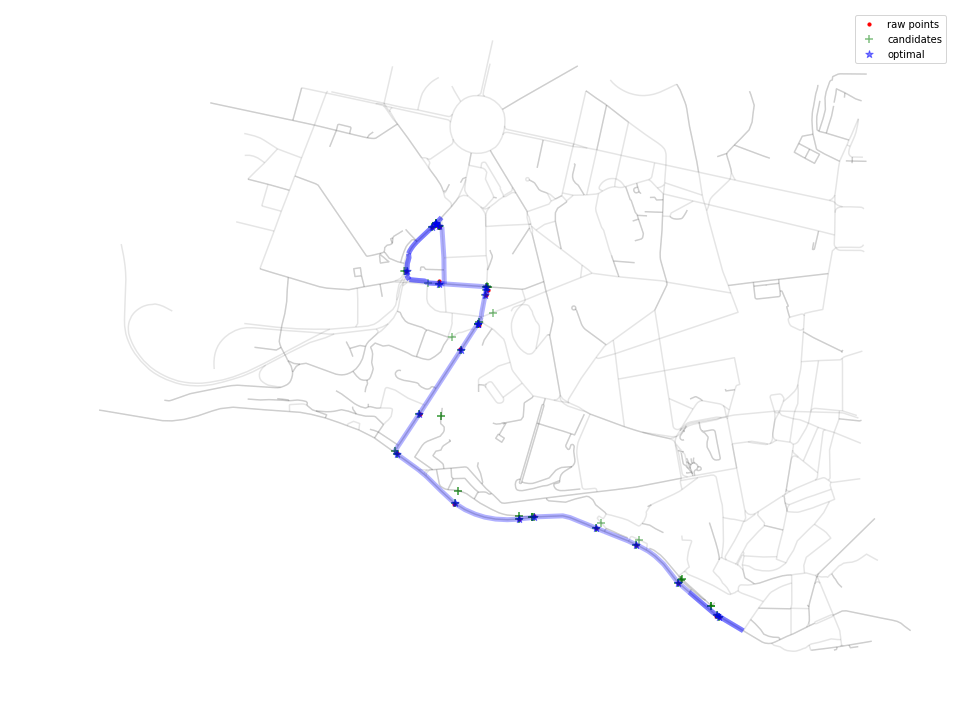

In [48]:
visualize_matching_results(trip, edge_idx, figname='matching_results0.pdf')

# Debug

(530888.1150080664, 530989.2696635303, 4555914.413236464, 4556012.760736597)

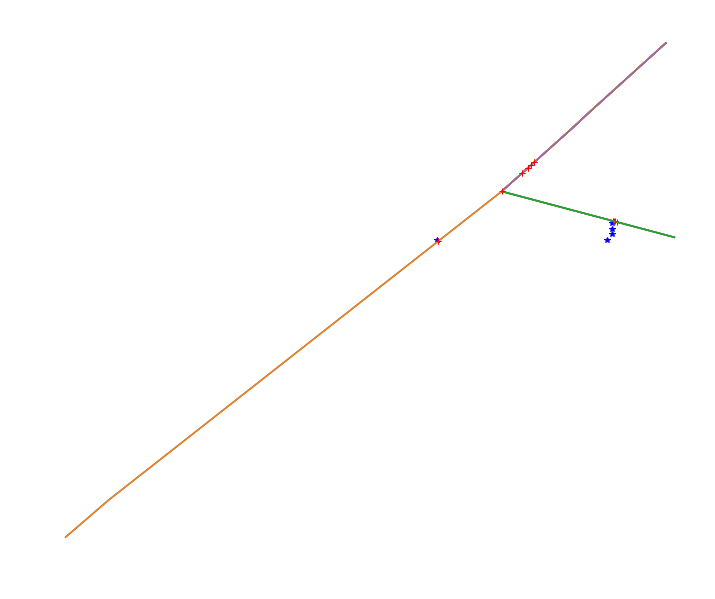

In [50]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString


def plot_candidates(ax, trip, idx):   
    # the raw point
    point = trip.iloc[idx]['geometry_utm']
    ax.plot(point.x, point.y, '*', color='blue', label='raw point', zorder=1)
    for i in range(len(trip.iloc[idx]['candidates'])):
        # the i-th nearest road segment
        edge_start = trip.iloc[idx]['candidates'].iloc[i]['from']
        edge_to = trip.iloc[idx]['candidates'].iloc[i]['to']
        #line = road_graph_utm[edge_start][edge_to][0]['geometry']
        line = trip.iloc[idx]['candidates'].iloc[i]['road']['geometry']
        x,y = line.xy
        ax.plot(x,y, zorder=i+2)
        # the projected point on the road segment
        proj_point = trip.iloc[idx]['candidates'].iloc[i]['proj_point']
        ax.plot(proj_point.x, proj_point.y, '+', color='red', label='projected point', zorder=i+3)

fig, ax= plt.subplots(figsize=(12,10))
plot_candidates(ax, trip, 18)
plot_candidates(ax, trip, 19)
plot_candidates(ax, trip, 20)
plot_candidates(ax, trip, 21)
plot_candidates(ax, trip, 22)
ax.axis('off')

(531894.575414495, 532115.8365844152, 4554463.706233757, 4554621.659227292)

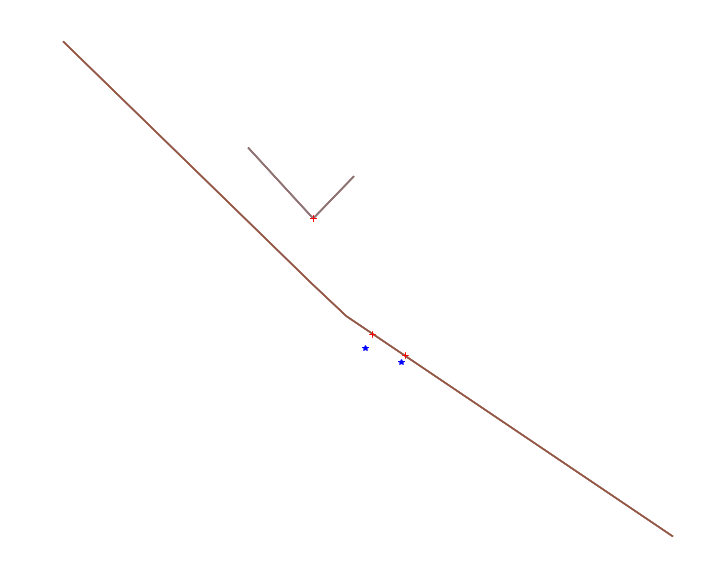

In [56]:
fig, ax= plt.subplots(figsize=(12,10))
plot_candidates(ax, trip, 0)
plot_candidates(ax, trip, 1)
#plot_candidates(ax, trip, 2)
#plot_candidates(ax, trip, 3)
#plot_candidates(ax, trip, 22)
ax.axis('off')

In [59]:
trip['weights'].iloc[1][0]

,from_id,to_id,sp distance,gc distance,avg speed(km/h),sp edges,transmission prob,temporal prob,weight,weight_sum
0,0,0,-12.420792,12.728537,0,"[[286969943, 1788784885, LINESTRING (532105.77...",0.975822,0,0.000000,0.035213
1,1,0,217.906124,12.728537,52.2975,"[[1788784885, 286969943, LINESTRING (531904.63...",0.058413,1,0.002274,0.037487
2,2,0,496.209330,12.728537,119.09,"[[475564016, 2915001116, LINESTRING (531965.76...",0.025652,0.907265,0.000906,0.000913
3,3,0,460.234160,12.728537,110.456,"[[2915001116, 475564016, LINESTRING (532000.40...",0.027657,0.900686,0.000970,0.000977
